<a href="https://colab.research.google.com/github/S-Li/msci-nlp-w22/blob/main/fnc-1/FNC_1_MSCI_598_related.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/GitHub/fnc-1

/content/drive/MyDrive/GitHub/fnc-1


### 0. Set-up

In [ ]:
# %cd drive/MyDrive/GitHub/
# !git clone https://github.com/FakeNewsChallenge/fnc-1

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 43.1 MB/s 
     |████████████████████████████████| 895 kB 36.6 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 32.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

transformers.logging.set_verbosity_error()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preprocessing

### 1. Dataset Balancing


In [ ]:
stances = ['agree', 'disagree', 'discuss']

In [ ]:
# get csv stances files for training and competition test
df_stances_train = pd.read_csv("train_stances.csv")
df_stances_test = pd.read_csv("competition_test_stances.csv")

length of filtered training set: 49972


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'article stance')

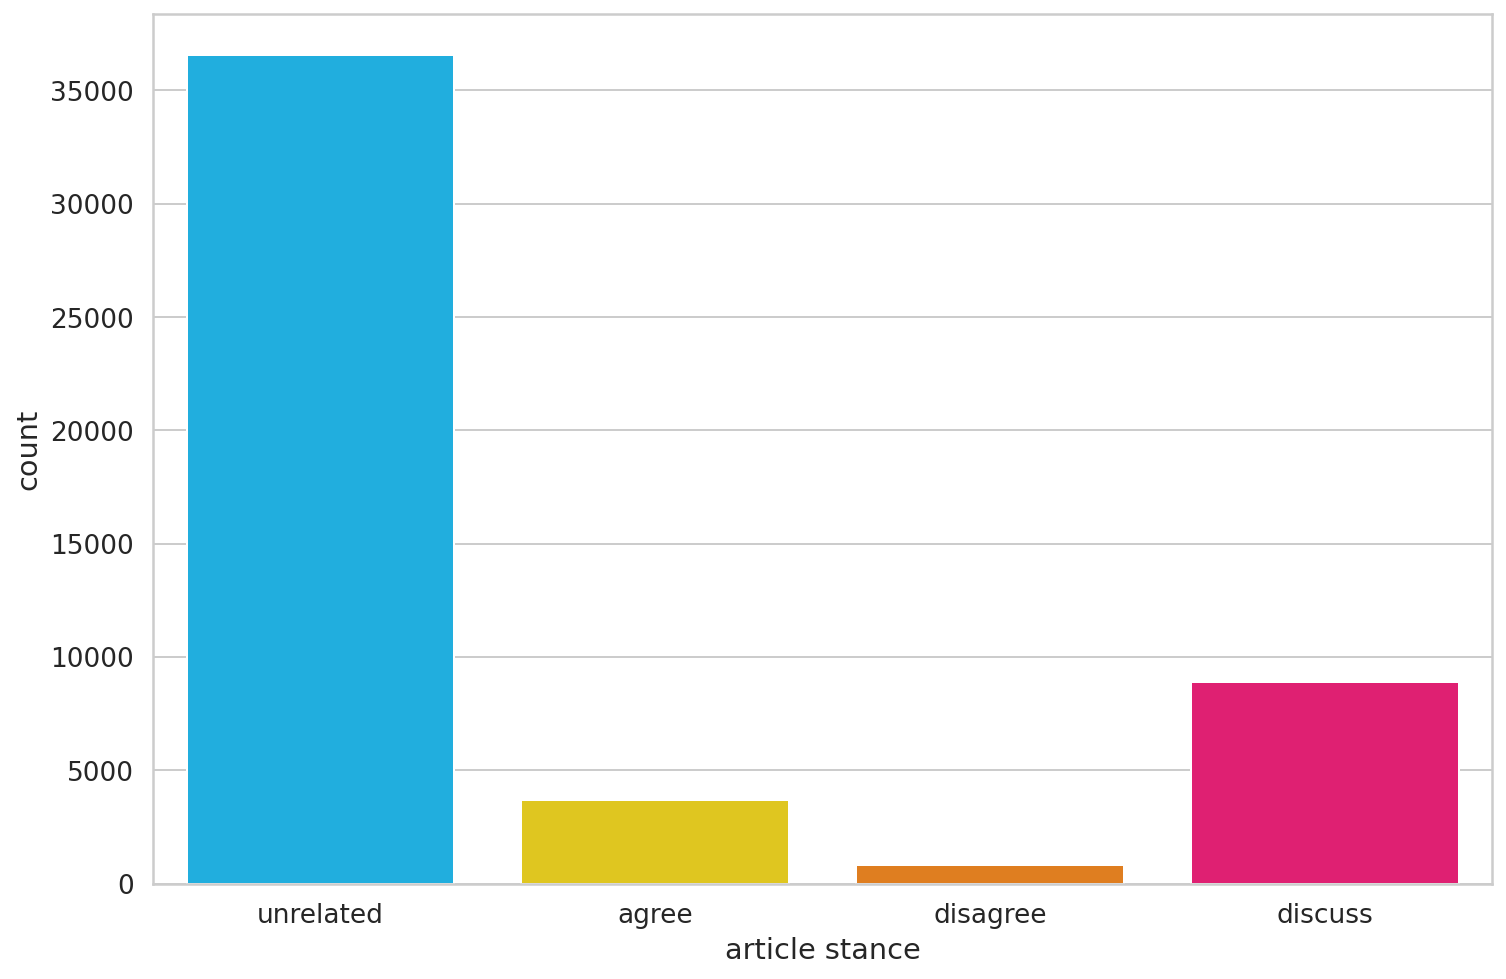

In [ ]:
print(f"length of filtered training set: {len(df_stances_train)}")
sns.countplot(df_stances_train.Stance)
plt.xlabel('article stance')

In [ ]:
# add a new column to the stance training df
# (for data augmentation use later)
df_stances_train['bodyDs'] = 1

In [ ]:
# collect all disagreeing stances for data augmentation
df_stances_train_disagree = df_stances_train[df_stances_train["Stance"] == "disagree"]
df_stances_train_agree = df_stances_train[df_stances_train["Stance"] == "agree"]
df_stances_train_discuss = df_stances_train[df_stances_train["Stance"] == "discuss"]

# collect all related stances for testing
df_stances_test_filtered = df_stances_test[df_stances_test["Stance"] != "unrelated"]
df_stances_test_filtered.sort_index(axis=0, inplace=True)

In [ ]:
print("disagree training data length: ", len(df_stances_train_disagree))
df_stances_train_disagree.head()

disagree training data length:  840


,Headline,Body ID,Stance,bodyDs
4,Spider burrowed through tourist's stomach and ...,1923,disagree,1
53,Pope Francis turns out not to have made pets i...,1905,disagree,1
60,"No, it's not Tiger Woods selling an island in ...",965,disagree,1
166,ADVISORY-Islamist rebel leader killed in U.S. ...,313,disagree,1
172,Weather Reporter Caught Writing His Name In Th...,975,disagree,1


In [ ]:
# get the csv body files for training and competition test
df_body_train = pd.read_csv("train_bodies.csv")
df_body_test = pd.read_csv("competition_test_bodies.csv")

In [ ]:
# add a new column to the body training df
# (for data augmentation use later)
df_body_train['bodyDs'] = 1

In [ ]:
# collect all disagreeing body articles for data augmentation
# get unique list of disagreeing body ids
body_ids_disagree = df_stances_train_disagree['Body ID'].tolist()
body_ids_disagree = list(set(body_ids_disagree))
print(len(body_ids_disagree))

# get filtered body dataset 
df_body_train_disagree = df_body_train[df_body_train['Body ID'].isin(body_ids_disagree)]
df_body_train_rest = df_body_train[~df_body_train['Body ID'].isin(body_ids_disagree)]

291


In [ ]:
print(df_body_train_disagree)
print(df_body_train_rest)

      Body ID                                        articleBody  bodyDs
52         78  This rumour is ridiculous, but it's pretty amu...       1
56         83  There's not being ready to go on camera. And t...       1
81        124  Some might say that no matter how rich you are...       1
114       176  Hunky mensch who took down violent bully looks...       1
140       218  The leader of the Catholic Church has assured ...       1
...       ...                                                ...     ...
1669     2514  So… Rebecca Schoenkopf over at Wonkette is pre...       1
1670     2515  Et si Dieu était une femme? C'est ce qu'affirm...       1
1671     2519  On Friday, a rumor cropped up that one of the ...       1
1673     2521  The hoax story has been circulating far and wi...       1
1679     2529  While Daleks "know no fear" and "must not fear...       1

[291 rows x 3 columns]
      Body ID                                        articleBody  bodyDs
0           0  A small mete

### 3.1 Data augmentation for disagree class

In [ ]:
!pip install deep-translator

     |████████████████████████████████| 128 kB 8.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# augmenting the disagreeing headlines and body articles datasets by 
# 1) replacing words with synonyms
# 2) machine translation
import math
import nltk
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
import random
from deep_translator import GoogleTranslator
from deep_translator import PonsTranslator

# load nltk's English stopwords and don't find synonyms for these words.
stop = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# helper function for getting synonyms
def get_synonyms(word):
  word = word.lower()
  synonyms = set()

  for syn in wordnet.synsets(word):
    for l in syn.lemmas():
      synonym = l.name().replace("_", " ")
      synonym = synonym.replace("-", " ")
      synonym = synonym.lower()
      # don't include stop words as part of the synonyms list
      if synonym != word and synonym not in stop:
        synonyms.add(synonym)

  return list(synonyms)

In [ ]:
# syns = get_synonyms("last")
# syns

In [ ]:
# input: 
#   words: headlines already tokenized
#   n: the number of word replacements to do
def synonym_replacement(words, n=None):
  words = str(words)
  words = words.split()
  new_words = words.copy()
  # don't find synonyms for stop words
  random_word_list = list(set([word for word in words if word not in stop]))
  random.shuffle(random_word_list)
  if n == None:
    word_list_len = len(random_word_list)
    if word_list_len > 1:
      n = int(word_list_len/2)
    else:
      n = 1
  # print(f"random word list: {random_word_list}\n")
  num_replaced = 0
  for random_word in random_word_list:
    synonyms = get_synonyms(random_word)

    if len(synonyms) >= 1:
      synonym = random.choice(synonyms)
      new_words = [synonym if word == random_word else word for word in new_words]
      num_replaced += 1

    # only replace up to n words
    if num_replaced >= n:
      break

  text = ' '.join(new_words)

  return text

In [ ]:
headline = df_stances_train_disagree.iloc[4]['Headline']
print(headline)
headline = synonym_replacement(headline)
print(headline)

Weather Reporter Caught Writing His Name In The Snow Was NOT Ready To Go On Camera (UPDATED)
atmospheric condition newsperson enchant drop a line His identify In The Snow comprise NOT cook To go bad On Camera (UPDATED)


In [ ]:
def translate(words):
  # google translate has a 5k character limit
  lim = 2500
  word_batches = []
  if len(words) > lim:
    num_groups = math.ceil(len(words)/lim)
    index_s = 0
    index_f = lim
    for i in range(num_groups):
      if i < num_groups - 1:
        word_batch = words[index_s:index_f]
        index_s += lim
        index_f += lim
      if i == num_groups - 1:
        word_batch = words[index_s:]
      word_batches.append(word_batch)
  else:
    word_batches.append(words)

  lang_1_list = ['greek', 'polish', 'japanese', 'haitian creole', 'finnish']
  lang_2_list = ['hebrew', 'arabic', 'chinese (simplified)', 'danish', 'czech']
  #lang_3_list = ['icelandic', 'russian', 'malay', 'french', 'portuguese']
  lang_1 = random.choice(lang_1_list)
  lang_2 = random.choice(lang_2_list)
  #lang_3 = random.choice(lang_3_list)

  new_words = []
  for word in word_batches:
    new_word = GoogleTranslator(source='auto', target=lang_1).translate(word)
    new_word = GoogleTranslator(source='auto', target=lang_2).translate(new_word)
    #new_word = GoogleTranslator(source='auto', target=lang_3).translate(new_word)
    new_word = GoogleTranslator(source='auto', target='english').translate(new_word)
    new_words.append(new_word)
  
  final_words = " ".join(new_words)
  
  return final_words

In [ ]:
def text_transform(words):
  new_words = synonym_replacement(words)
  new_words = translate(new_words)
  print(f'words: {words}\n\nnew words: {new_words}\n-------------------------------------------\n')
  return new_words

In [ ]:
# verifying text transform function
sample_body = df_body_train_disagree.iloc[1]['articleBody']
new_sample_body = text_transform(sample_body)
# print(f"sample_body: {sample_body}\nnew_sample_body: {new_sample_body}")

words: There's not being ready to go on camera. And then there's really, really not being ready. Like, not even a little bit.

This was the unfortunate case experienced by meteorologist Mike Seidel this weekend while reporting on the stormy weather in North Carolina.

There has been some speculation as to what Mike was or was not doing. Think what you will:

H/T FTVLive

UPDATE: Nov. 4-- Brian Williams issued a statement during "Nightly News" Monday night to clear up the confusion about what Seidel was actually doing.

"Mike had lost cellphone contact with our control room, so he couldn’t hear through his attached earpiece that he was on the air," Williams said. "He put his back to the storm and the camera -- he had to take off his gloves and re-dial his phone which was tethered to his ear, that’s when the rumors hit the web that he was perhaps writing his name in the snow. It was just Mike working to make it right — which is why we all love working with Mike Seidel.”

Watch below:

ne

In [ ]:
# augment disagree stance data set to be same length as agree dataset
len_agree = len(df_stances_train_agree)
len_disagree = len(df_stances_train_disagree)
diff_factor = int(len_agree/len_disagree)
print(diff_factor)

4


In [ ]:
# synonym replacement the disagree headlines 4 times
# final disagree stance dataset length will be 5x original

# make a list of dataframes
df_temps = []

for i in range(diff_factor):
  df_temps.append(df_stances_train_disagree.copy())

for i in range(diff_factor):
  df_temps[i]["Headline"] = df_temps[i]['Headline'].apply(synonym_replacement)
  df_temps[i]["bodyDs"] = df_temps[i]["bodyDs"].apply(lambda x: x + i + 1)
  df_stances_train_disagree = pd.concat([df_stances_train_disagree, df_temps[i]])

In [ ]:
df_stances_train_disagree = df_stances_train_disagree.drop_duplicates()

In [ ]:
df_stances_train_filtered = pd.concat([df_stances_train_agree, df_stances_train_disagree, df_stances_train_discuss])

In [ ]:
from sklearn.utils import shuffle
df_stances_train_filtered = shuffle(df_stances_train_filtered)

In [ ]:
df_stances_train_filtered.reset_index(drop=True, inplace=True)

In [ ]:
df_stances_train_filtered

,Headline,Body ID,Stance,bodyDs
0,"Batmobile Stolen From ""Batman v Superman: Dawn...",1538,discuss,1
1,"Meteorite makes big crater in Nicaragua, gover...",221,agree,1
2,Surreal Photos of Fisherman’s Jaw-Dropping Cat...,842,discuss,1
3,Comcast Declares War on Tor?,1403,discuss,1
4,An Audio Recording of the Michael Brown Shooti...,1916,discuss,1
...,...,...,...,...
16771,Nigeria: hopes for return of kidnapped schoolg...,1298,discuss,1
16772,Amazon plans a streaming-video alternative,2152,discuss,1
16773,more than than 200 kidnap nigerien female chil...,1885,disagree,3
16774,Jilted lover spends a week in KFC to try and g...,1551,agree,1


length of filtered training set: 16776


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'article stance')

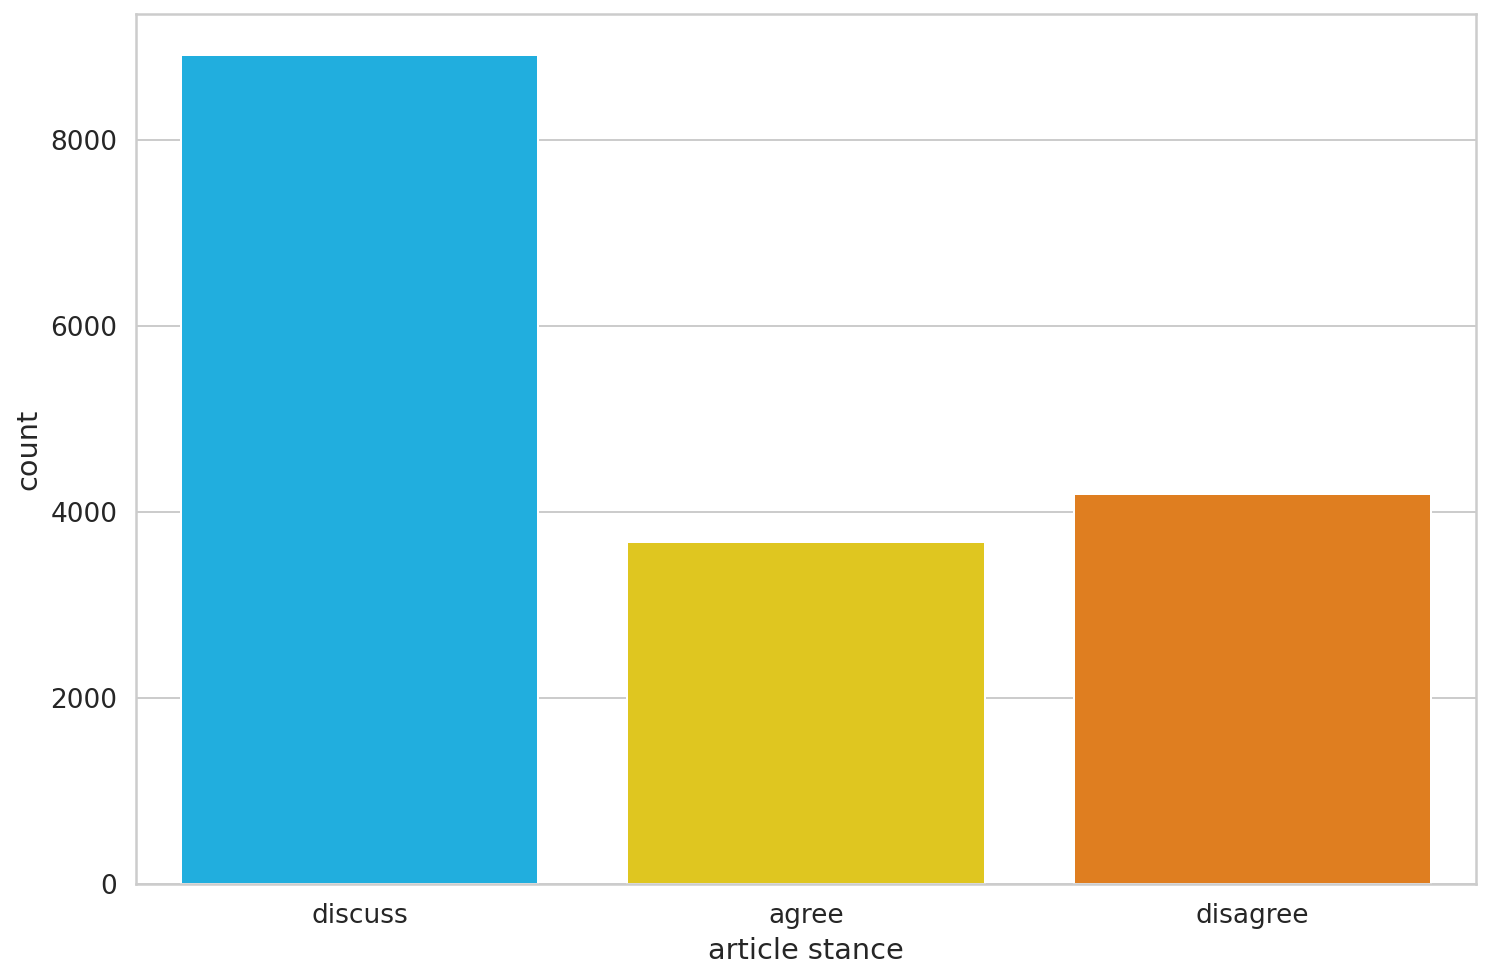

In [ ]:
print(f"length of filtered training set: {len(df_stances_train_filtered)}")
sns.countplot(df_stances_train_filtered.Stance)
plt.xlabel('article stance')

In [ ]:
# # text transform the disagree body articles 1 time
# df_temp = df_body_train_disagree.copy()
# df_temp['articleBody'] = df_temp['articleBody'].apply(text_transform)
# df_temp['bodyDs'] = df_temp['bodyDs'].apply(lambda x: x + 1)
# df_body_train_disagree = pd.concat([df_body_train_disagree, df_temp])

In [ ]:
df_temp = pd.read_csv('translated_train_bodies.csv')
df_body_train_disagree = pd.concat([df_body_train_disagree, df_temp])

In [ ]:
df_body_train_filtered = pd.concat([df_body_train_rest, df_body_train_disagree])

In [ ]:
df_body_train_filtered.loc[df_body_train_filtered['Body ID'] == 2514]


,Body ID,articleBody,bodyDs
1669,2514,So… Rebecca Schoenkopf over at Wonkette is pre...,1
286,2514,So...rebekah Schoenkopf in Wonkette is pretty ...,2


### 2. Tokenization

In [ ]:
pretrained_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


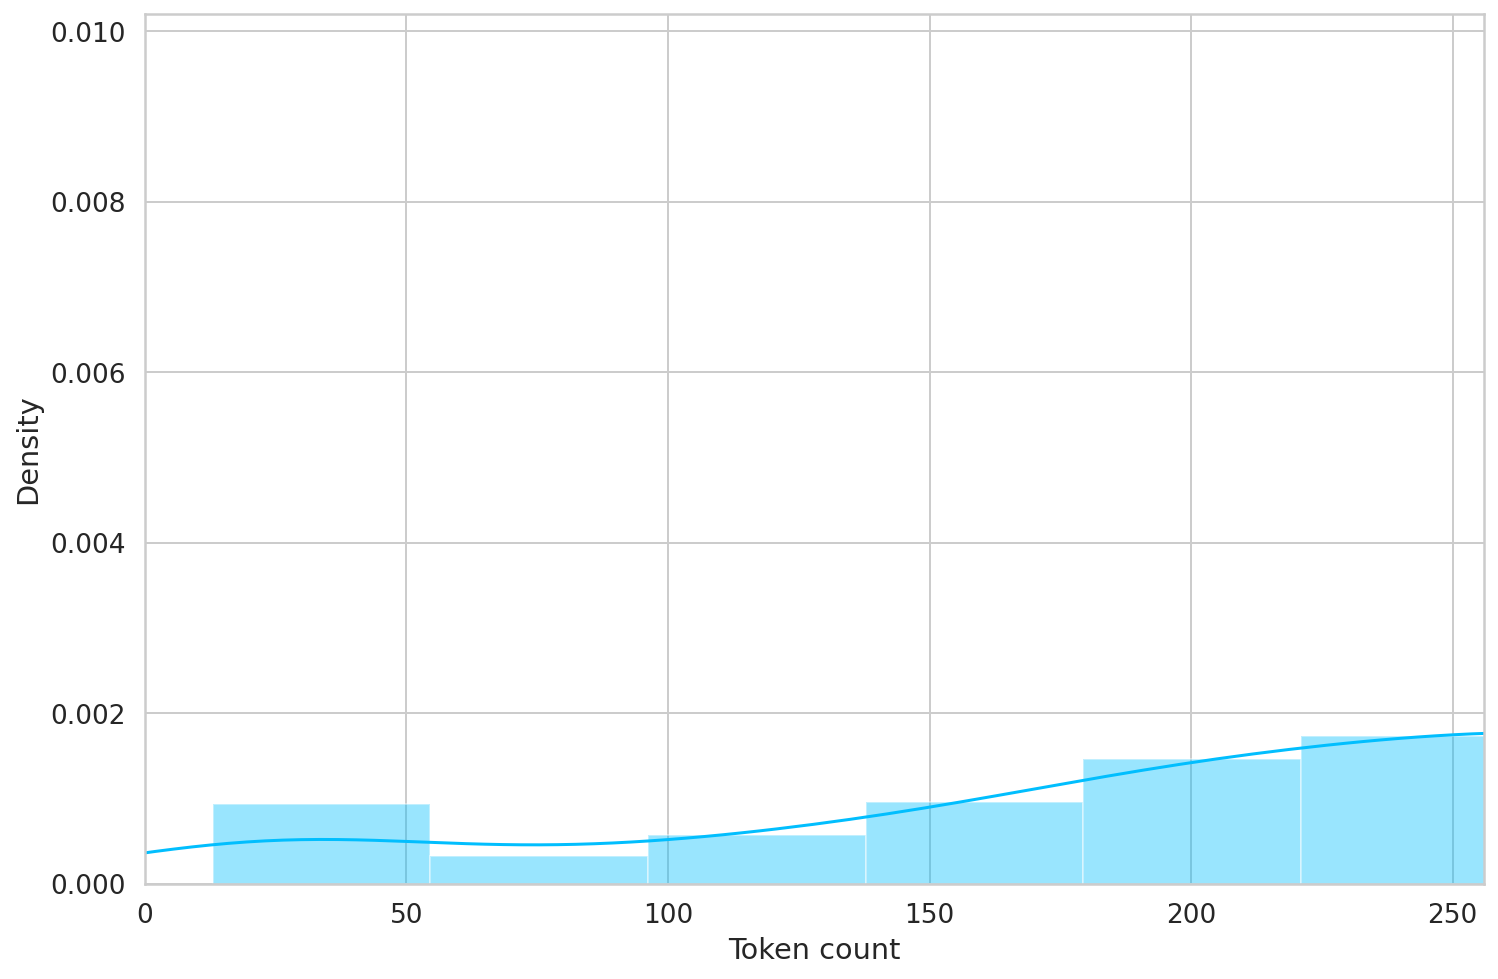

In [ ]:
# choosing sequence length
token_lens = []

for txt in df_body_train.articleBody:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

# plot distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
max_len = 250

## Model Functions

In [ ]:
class ArticleDataset(Dataset):

  # takes in headlines and bodies from the original corpus
  # just send in the pandas dataframe
  def __init__(self, headlines, bodies, tokenizer, max_len, ds_type='train'):
    self.headlines = headlines
    self.bodies = bodies
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.stances = ['agree', 'disagree', 'discuss']
    self.ds_type = ds_type
  
  def __len__(self):
    return len(self.headlines)
  
  # return the headline, body article, input_ids, attention masks, and stance
  def __getitem__(self, item):
    sample_headline = self.headlines.iloc[item, 0]
    body_id = self.headlines.iloc[item, 1]
    stance = self.stances.index(self.headlines.iloc[item, 2])
    
    if self.ds_type == 'train':
      headline_ds = self.headlines.iloc[item, 3] # identifying augmented data
      # original headlines -> original body articles
      if headline_ds == 1:
        sample_body = self.bodies.loc[(self.bodies["Body ID"] == body_id) & (self.bodies['bodyDs'] == 1), "articleBody"].item()
      # if the headline stance is disagree, it will have ds = [1:5], where ds = [2:5] are the augmented stances
      elif 2 <= headline_ds <= 5:
        if 2 <= headline_ds <= 3:
          sample_body = self.bodies.loc[(self.bodies['Body ID'] == body_id) & (self.bodies['bodyDs'] == 1), 'articleBody'].item()
        else:
          sample_body = self.bodies.loc[(self.bodies['Body ID'] == body_id) & (self.bodies['bodyDs'] == 2), 'articleBody'].item()
    elif self.ds_type == 'test':
      sample_body = self.bodies.loc[self.bodies["Body ID"] == body_id, "articleBody"].item()

    encoding = self.tokenizer(
      sample_headline,
      sample_body,
      max_length = max_len,
      padding='max_length',
      truncation = True,
      return_tensors = 'pt',
    )

    return {
      'headline': sample_headline,
      'article_body': sample_body,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'stance': torch.tensor(stance)
    }

In [ ]:
batch_size = 16

In [ ]:
# helper function to create a data loader
def create_data_loader(df_s, df_b, tokenizer, max_len, batch_size, ds_type='train'):
  ds = ArticleDataset(
    headlines = df_s,
    bodies = df_b,
    tokenizer=tokenizer,
    max_len=max_len,
    ds_type=ds_type
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
  )

In [ ]:
train_data_loader = create_data_loader(df_stances_train_filtered, df_body_train_filtered, tokenizer, max_len, batch_size, ds_type='train')
test_data_loader = create_data_loader(df_stances_test_filtered, df_body_test, tokenizer, max_len, batch_size, ds_type='test')

In [ ]:
class StanceClassifier(nn.Module):

  def __init__(self, n_classes):
    super(StanceClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    X = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask,
    )
  
    output = self.drop(X[1])
    return self.out(output)

In [ ]:
model = StanceClassifier(3)
model = model.to(device)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [ ]:
# calculating the weights for loss balancing
len_agree = len(df_stances_train_agree)
len_disagree = len(df_stances_train_disagree)
len_discuss = len(df_stances_train_discuss)
len_total = len(df_stances_train_filtered)
print(len_agree, len_disagree, len_discuss, len_total)

scaling_factor_agree = 0.6
scaling_factor_disagree = 1.4
weight_agree = (len_total/3/len_agree)*scaling_factor_agree
weight_disagree = (len_total/3/len_disagree)*scaling_factor_disagree
weight_discuss = len_total/3/len_discuss
weights = torch.tensor([weight_agree, weight_disagree, weight_discuss])
print(weights)

3678 4188 8909 16775
tensor([0.9122, 1.8692, 0.6276])


In [ ]:
# training
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# helper function for training model for one epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i, d in enumerate(data_loader):
    print(f"Batch: {i}")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    stance = d["stance"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, stance)

    correct_predictions += torch.sum(preds == stance)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for i,d in enumerate(data_loader):
      print(f"Batch: {i}")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, stance)

      correct_predictions += torch.sum(preds == stance)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
EPOCHS = 3

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_stances_train_filtered)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  # val_acc, val_loss = eval_model(
  #     model,
  #     val_data_loader,
  #     loss_fn, 
  #     device, 
  #     len(df_stances_val)
  # )

  # print(f'Val   loss {val_loss} accuracy {val_acc}')
  # print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  # history['val_acc'].append(val_acc)
  # history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
    checkpoint = {
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, 'best_model_state.bin')
    best_accuracy = train_acc

In [ ]:
# helper function to get predictions - similar to evaluation but storing
# review texts and probabilities
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      stance = d["stance"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(stance)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [ ]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=stances))

              precision    recall  f1-score   support

       agree       0.57      0.69      0.62      1903
    disagree       0.52      0.07      0.12       697
     discuss       0.83      0.88      0.85      4464

    accuracy                           0.75      7064
   macro avg       0.64      0.54      0.53      7064
weighted avg       0.73      0.75      0.72      7064



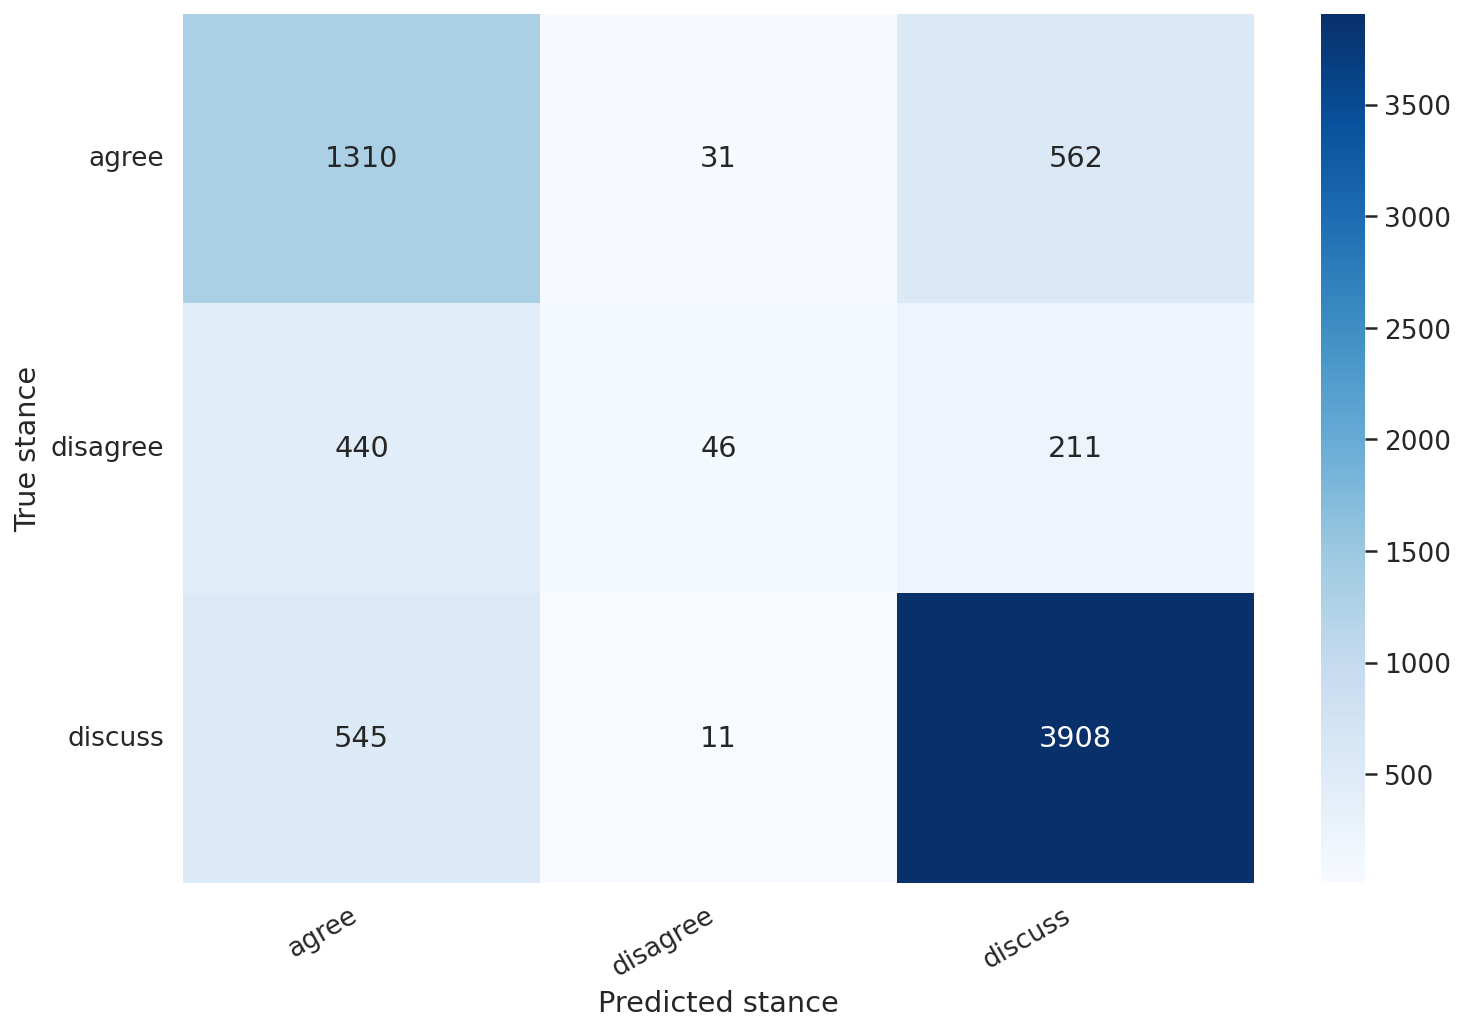

In [ ]:
# confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True stance')
  plt.xlabel('Predicted stance');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=stances, columns=stances)
show_confusion_matrix(df_cm)